         Date  Day     Month  Year  Customer_Age       Age_Group  \
0  2013-11-26   26  November  2013            19     Youth (<25)   
1  2015-11-26   26  November  2015            19     Youth (<25)   
2  2014-03-23   23     March  2014            49  Adults (35-64)   
3  2016-03-23   23     March  2016            49  Adults (35-64)   
4  2014-05-15   15       May  2014            47  Adults (35-64)   

  Customer_Gender    Country             State Product_Category Sub_Category  \
0               M     Canada  British Columbia      Accessories   Bike Racks   
1               M     Canada  British Columbia      Accessories   Bike Racks   
2               M  Australia   New South Wales      Accessories   Bike Racks   
3               M  Australia   New South Wales      Accessories   Bike Racks   
4               F  Australia   New South Wales      Accessories   Bike Racks   

               Product  Order_Quantity  Unit_Cost  Unit_Price  Profit  Cost  \
0  Hitch Rack - 4-Bike         

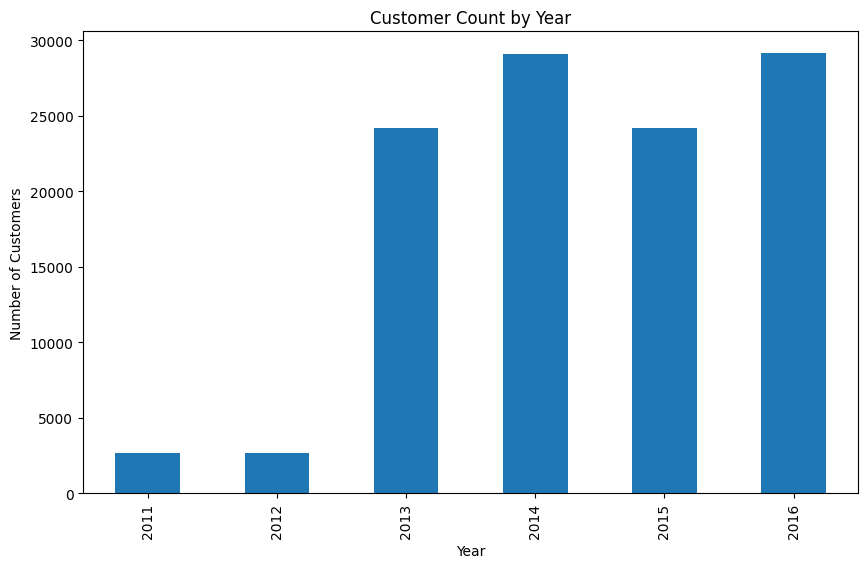

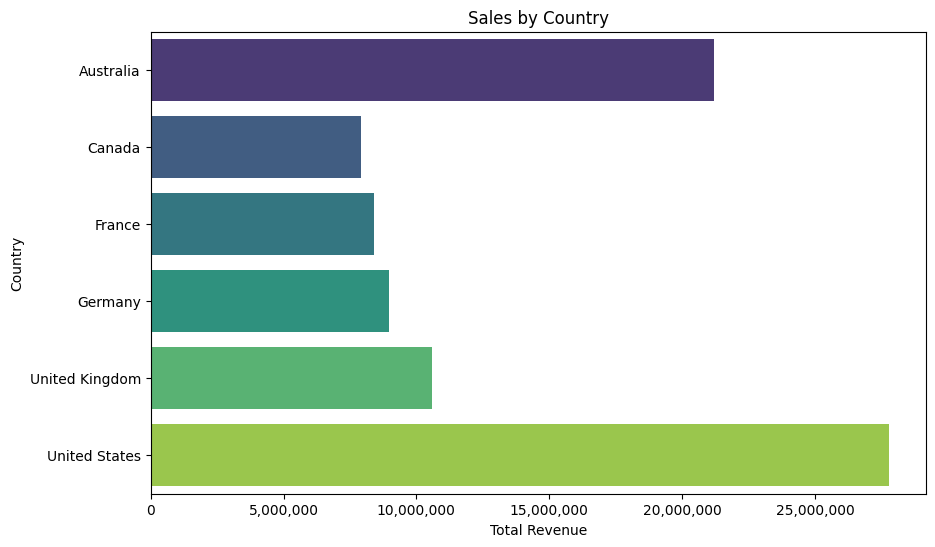

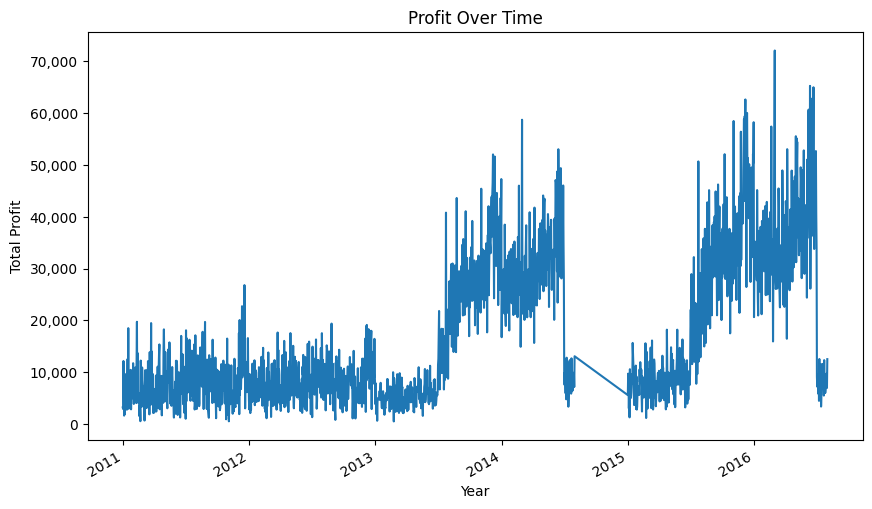

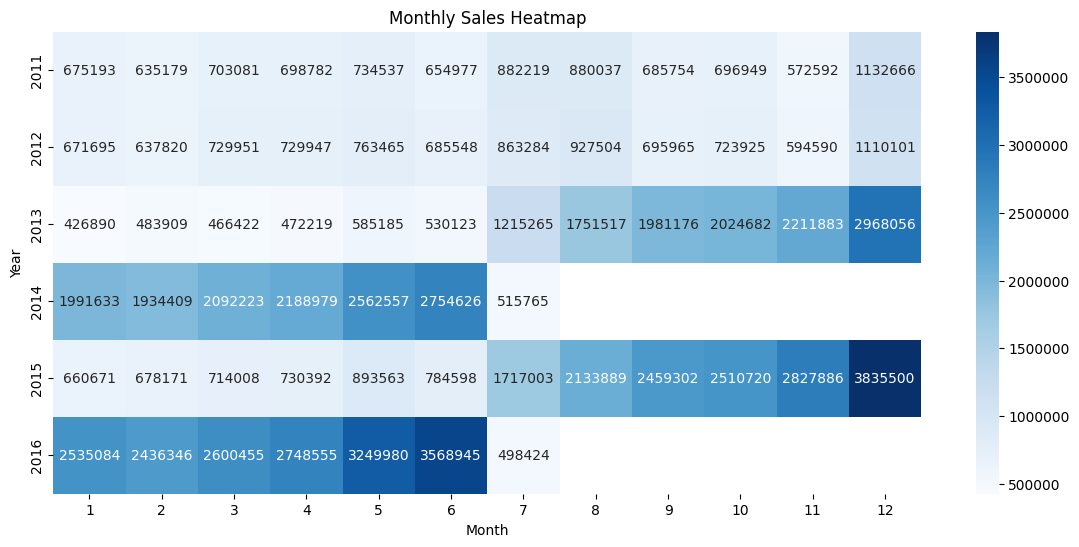

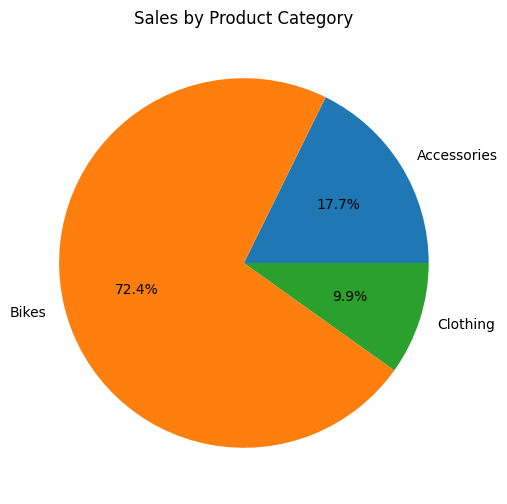

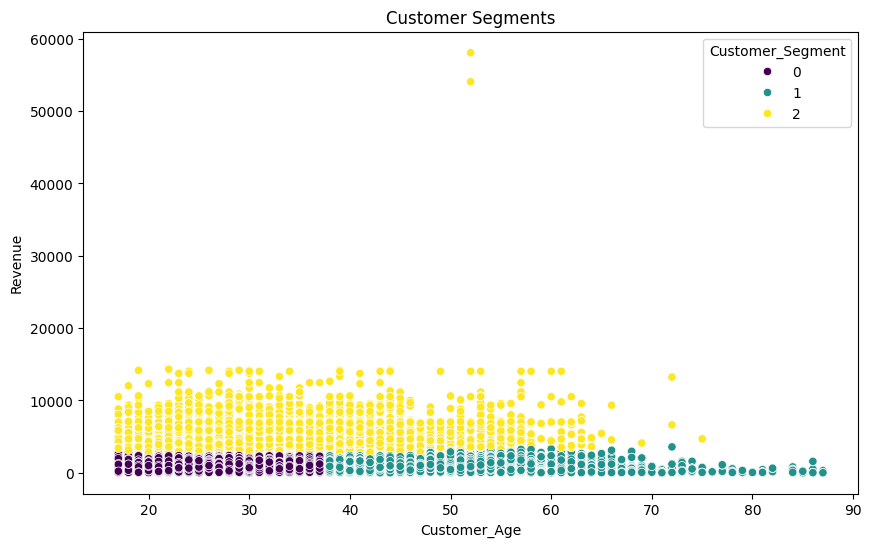

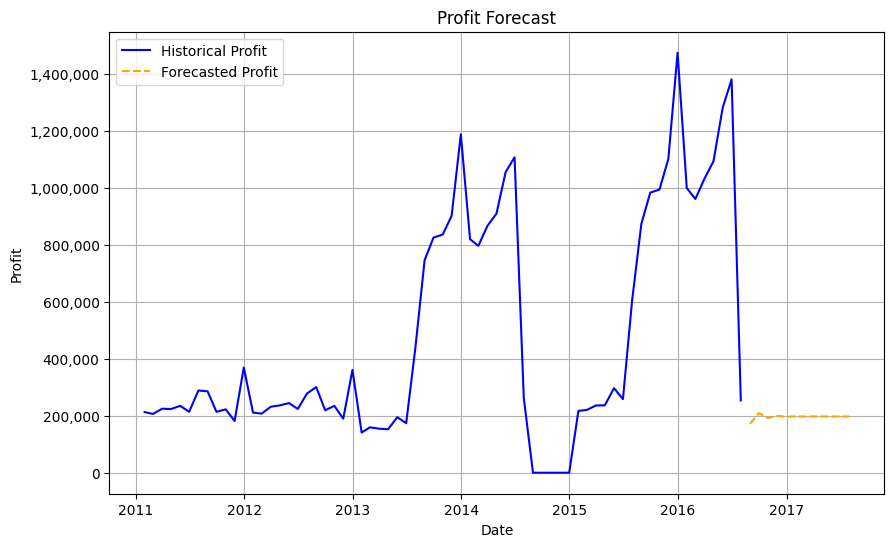

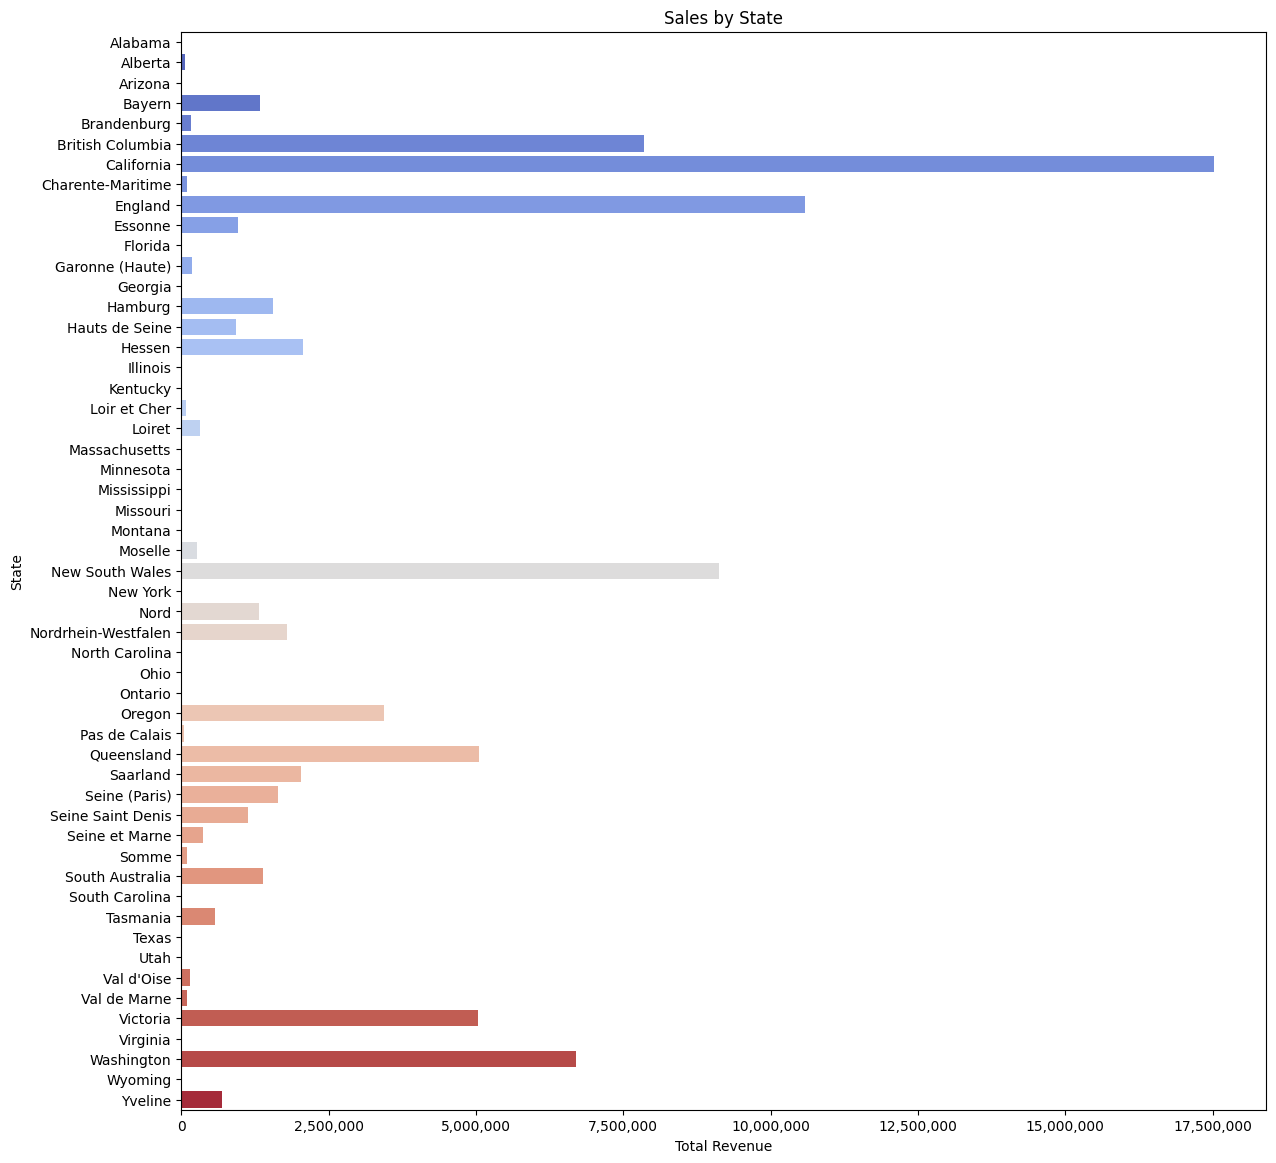

Accuracy of the product recommendation model: 83.63%
Accuracy of the Naive Bayes product recommendation model: 76.78%


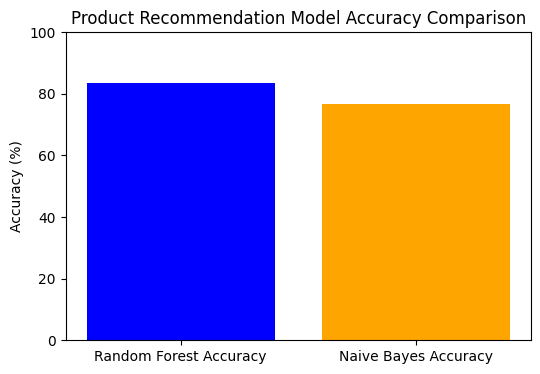

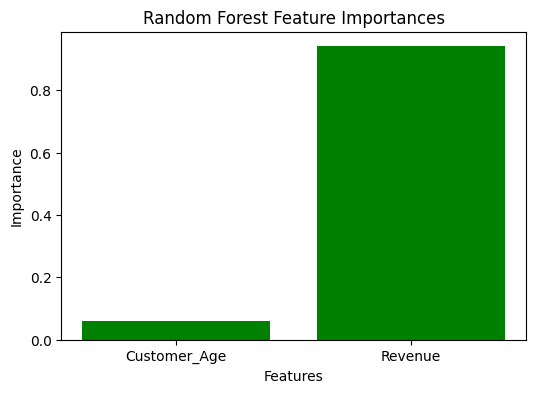

Predicted Product Category (Random Forest) for new customer: Accessories
Predicted Product Category (Naive Bayes) for new customer: Accessories


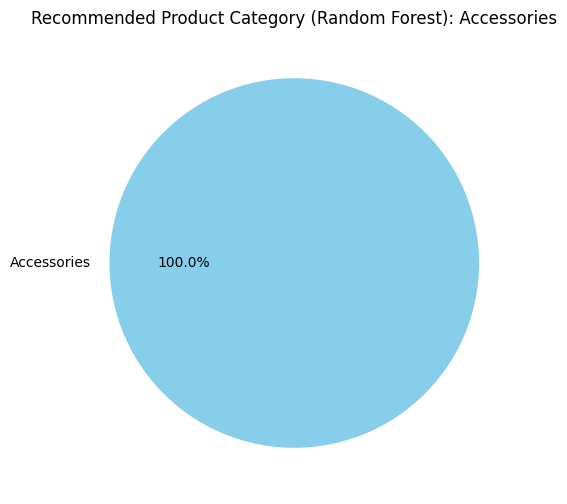

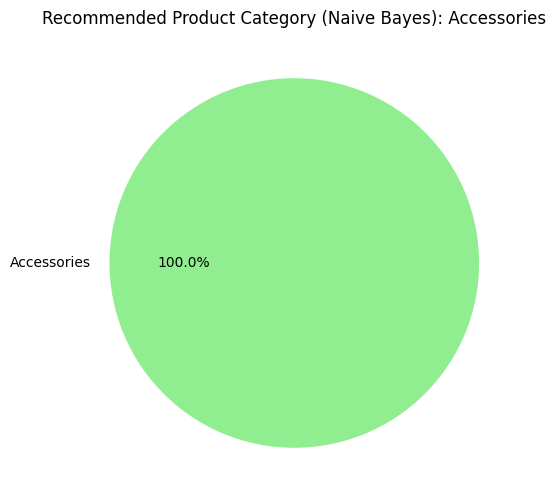

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
import statsmodels.api as sm
import warnings

# Ignore warnings to keep the output clean
warnings.filterwarnings("ignore")

# Load CSV file (adjust file path to your local directory)
file_path = 'E:/data set/sales.csv'
data = pd.read_csv(file_path)

# Basic information about the dataset
print(data.head())  # Display first few rows of the data
print(data.info())  # Dataset structure (columns, types, non-null counts)
print(data.isnull().sum())  # Check for missing values
print(data.describe())  # Summary statistics of numerical columns

# Check and remove duplicate rows if any
duplicates = data.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")
data = data.drop_duplicates()

# Convert 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# Create 'Year' and 'Month' columns for time-based analysis
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month

# ------------------------ Customer Count by Year ------------------------
customer_count_by_year = data.groupby('Year')['Customer_Age'].count()

# Plot customer count by year
plt.figure(figsize=(10, 6))
customer_count_by_year.plot(kind='bar', title='Customer Count by Year')
plt.xlabel('Year')
plt.ylabel('Number of Customers')
plt.show()

# ------------------------ Regional Analysis by Country ------------------------
sales_by_country = data.groupby('Country')[['Revenue', '

                                            Profit']].sum().reset_index()

# Plot sales by country
plt.figure(figsize=(10, 6))
sns.barplot(data=sales_by_country, y='Country', x='Revenue', palette='viridis')
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.title('Sales by Country')
plt.xlabel('Total Revenue')
plt.ylabel('Country')
plt.show()

# ------------------------ Profit Over Time ------------------------
# Calculate profit over time (monthly aggregation)
profit_over_time = data.groupby('Date')['Profit'].sum()

# Plot profit over time
plt.figure(figsize=(10, 6))
profit_over_time.plot(title='Profit Over Time')
plt.xlabel('Year')
plt.ylabel('Total Profit')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

# ------------------------ Monthly Sales Heatmap ------------------------
# Create heatmap of monthly sales for the years in the dataset
monthly_sales_heatmap = data.pivot_table(values='Revenue', index=data['Year'], columns=data['Month'], aggfunc='sum')

# Plot monthly sales heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(monthly_sales_heatmap, cmap='Blues', annot=True, fmt=".0f", cbar_kws={'format': '%.0f'})
plt.title('Monthly Sales Heatmap')
plt.xlabel('Month')
plt.ylabel('Year')
plt.show()

# ------------------------ Sales by Product Category ------------------------
sales_by_category = data.groupby('Product_Category')['Revenue'].sum()

# Plot sales by product category
plt.figure(figsize=(12, 6))
sales_by_category.plot(kind='pie', title='Sales by Product Category', autopct='%1.1f%%')
plt.ylabel('')
plt.show()

# ------------------------ Customer Segmentation Using KMeans ------------------------
# Prepare data for KMeans clustering: features - 'Customer_Age' and 'Revenue'
segmentation_data = data[['Customer_Age', 'Revenue']].dropna()

# Normalize data for clustering
scaler = StandardScaler()
segmentation_data_scaled = scaler.fit_transform(segmentation_data)

# Apply KMeans clustering to segment customers into 3 clusters
kmeans = KMeans(n_clusters=3)
data['Customer_Segment'] = kmeans.fit_predict(segmentation_data_scaled)

# Visualize customer segments
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['Customer_Age'], y=data['Revenue'], hue=data['Customer_Segment'], palette='viridis')
plt.title('Customer Segments')
plt.show()

# ------------------------ ARIMA Model for Profit Forecasting ------------------------
# Aggregate profit by month and apply ARIMA model for forecasting
monthly_profit = data.groupby(pd.Grouper(key='Date', freq='M'))['Profit'].sum()
monthly_profit.index = pd.to_datetime(monthly_profit.index)

# Fit ARIMA model
model = sm.tsa.ARIMA(monthly_profit, order=(1, 1, 1))
model_fit = model.fit()

# Forecast profit for the next 12 months
forecast = model_fit.forecast(steps=12)
forecast_index = pd.date_range(start=monthly_profit.index[-1] + pd.Timedelta(days=1), periods=12, freq='M')

# Plot profit forecast
plt.figure(figsize=(10, 6))
plt.plot(monthly_profit.index, monthly_profit, label='Historical Profit', color='blue')
plt.plot(forecast_index, forecast, label='Forecasted Profit', linestyle='--', color='orange')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.title('Profit Forecast')
plt.xlabel('Date')
plt.ylabel('Profit')
plt.legend()
plt.grid()
plt.show()

# ------------------------ Sales by State ------------------------
# Regional sales analysis by state (assuming 'State' column exists in the dataset)
sales_by_state = data.groupby('State')[['Revenue', 'Profit']].sum().reset_index()

# Plot sales by state
if not sales_by_state.empty:
    plt.figure(figsize=(14, 14))
    sns.barplot(data=sales_by_state, x='Revenue', y='State', palette='coolwarm')
    plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    plt.title('Sales by State')
    plt.xlabel('Total Revenue')
    plt.ylabel('State')
    plt.show()
else:
    print("No data available for States.")

# ------------------------ Product Recommendation Using Random Forest Classifier ------------------------

# Prepare features and target for product recommendation model
features = ['Customer_Age', 'Revenue']
target = 'Product_Category'  # Assuming you have a 'Product_Category' column in your dataset

# Drop rows with missing values in the features or target column
data_clean = data.dropna(subset=features + [target])

# Prepare feature matrix X and target vector y
X = data_clean[features]
y = data_clean[target]

# Split the data into training and testing sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model to the training data
rf_model.fit(X_train, y_train)

# Predict the product category for the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model's accuracy
accuracy = (y_pred == y_test).mean()
print(f"Accuracy of the product recommendation model: {accuracy * 100:.2f}%")

# ------------------------ Naive Bayes Model for Product Recommendation ------------------------

# Initialize the Naive Bayes Classifier
nb_model = GaussianNB()

# Fit the Naive Bayes model to the training data
nb_model.fit(X_train, y_train)

# Predict the product category for the test set using Naive Bayes
y_pred_nb = nb_model.predict(X_test)

# Evaluate the Naive Bayes model's accuracy
accuracy_nb = (y_pred_nb == y_test).mean()
print(f"Accuracy of the Naive Bayes product recommendation model: {accuracy_nb * 100:.2f}%")

# ------------------------ Visualization of Model Accuracy ------------------------

# Bar plot to visualize model accuracy
plt.figure(figsize=(6, 4))
plt.bar(['Random Forest Accuracy', 'Naive Bayes Accuracy'], [accuracy * 100, accuracy_nb * 100], color=['blue', 'orange'])
plt.title('Product Recommendation Model Accuracy Comparison')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.show()

# ------------------------ Visualization of Feature Importances ------------------------

# Get feature importances from the trained Random Forest model
feature_importances = rf_model.feature_importances_
features = ['Customer_Age', 'Revenue']

# Bar plot to visualize feature importance
plt.figure(figsize=(6, 4))
plt.bar(features, feature_importances, color='green')
plt.title('Random Forest Feature Importances')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.show()

# ------------------------ Example: Predicting Product Category for a New Customer ------------------------

# Create a new customer with example features (age and revenue)
new_customer_data = pd.DataFrame({
    'Customer_Age': [30],  # Example age
    'Revenue': [500]       # Example revenue
})

# Predict the product category for this new customer using Random Forest
predicted_category_rf = rf_model.predict(new_customer_data)
print(f"Predicted Product Category (Random Forest) for new customer: {predicted_category_rf[0]}")

# Predict the product category for this new customer using Naive Bayes
predicted_category_nb = nb_model.predict(new_customer_data)
print(f"Predicted Product Category (Naive Bayes) for new customer: {predicted_category_nb[0]}")

# ------------------------ Visualization of Recommended Product Category ------------------------

# Visualize the recommended product category for the new customer using a pie chart
category_counts = {predicted_category_rf[0]: 1}

# Plot a pie chart for the recommended product category (Random Forest)
plt.figure(figsize=(6, 6))
plt.pie(category_counts.values(), labels=category_counts.keys(), autopct='%1.1f%%', colors=['skyblue'])
plt.title(f'Recommended Product Category (Random Forest): {predicted_category_rf[0]}')
plt.show()

# Visualize the recommended product category for the new customer using a pie chart (Naive Bayes)
category_counts_nb = {predicted_category_nb[0]: 1}

# Plot a pie chart for the recommended product category (Naive Bayes)
plt.figure(figsize=(6, 6))
plt.pie(category_counts_nb.values(), labels=category_counts_nb.keys(), autopct='%1.1f%%', colors=['lightgreen'])
plt.title(f'Recommended Product Category (Naive Bayes): {predicted_category_nb[0]}')
plt.show()